In [1]:
import sys
import os
from glob import glob
import pickle
import os
import urllib
from functools import reduce

from joblib import Parallel, delayed

from tqdm import tqdm

import numpy as np

import pandas as pd

from PIL import Image
from PIL import ImageEnhance

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF

sys.path.insert(0, os.getcwd())

# import all utils
from utils import data_directory, \
                dinov3_repo_dir, \
                dinov3_vitb16_weight_raw, \
                dinov3_vith16_weight_raw, \
                dinov3_vit7B16_weight_raw
    

In [2]:
forged_folder = os.path.join(data_directory, 'train_images', 'forged')
authentic_folder = os.path.join(data_directory, 'train_images', 'authentic')
mask_folder = os.path.join(data_directory, 'train_masks')

In [3]:
mask_files = glob(os.path.join(mask_folder, '*.npy'))

def process_mask(mask_file):
    
    ret = []
    
    mask_name = os.path.basename(mask_file).replace('.npy', '')
    
    if os.path.exists(os.path.join(forged_folder, mask_name+'.png')) is False:
        return ret
    forged_image_path = os.path.join(forged_folder, mask_name+'.png')
    forged_img = Image.open(forged_image_path).convert('RGB')

    if os.path.exists(os.path.join(authentic_folder, mask_name+'.png')) is False:
        return ret
    auth_image_path = os.path.join(authentic_folder, mask_name+'.png')
    auth_img = Image.open(auth_image_path).convert('RGB')
    
    masked_image_path = os.path.join(mask_folder, mask_name+'.npy')
    masked_imgs = np.load(masked_image_path)
    masked_imgs_shape = masked_imgs.shape
    
    # Subtract auth_img from forged_img and convert to boolean mask
    forged_array = np.array(forged_img)
    auth_array = np.array(auth_img)

    # Calculate absolute difference
    diff_array = np.abs(forged_array.astype(np.float32) - auth_array.astype(np.float32))

    # Convert to grayscale by taking mean across channels
    diff_gray = np.mean(diff_array, axis=2)

    # Create boolean mask (threshold can be adjusted)
    DIFF_THRESHOLD = 0  # Adjust this value as needed
    diff_boolean_mask = diff_gray > DIFF_THRESHOLD
    
    for i in range(masked_imgs_shape[0]):
    
        # get the i-th mask
        masked_img = masked_imgs[i]

        # Convert masked_img to boolean
        MASK_THRESHOLD = 0  # Adjust this value as needed
        masked_img_boolean = masked_img > MASK_THRESHOLD
        
        # find intersections between diff_boolean_mask and masked_img_boolean
        forged_mask = np.logical_and(diff_boolean_mask, masked_img_boolean)
        
        # get auth mask
        auth_mask = masked_img_boolean & ~forged_mask
    
    
        ret.append({"mask_name": mask_name, \
                    "index": i, \
                    "auth_mask": auth_mask, \
                    "forged_mask": forged_mask,})
    return ret

masked_entities = Parallel(n_jobs=-1)(delayed(process_mask)(mask_file) for mask_file in tqdm(mask_files))
masked_entities = [item for sublist in masked_entities for item in sublist]
pickle.dump(masked_entities, open('mask_components.pkl', 'wb'))

100%|██████████| 2751/2751 [02:23<00:00, 19.18it/s]


In [3]:
masked_entities = pickle.load(open('mask_components.pkl', 'rb'))

0it [00:00, ?it/s]

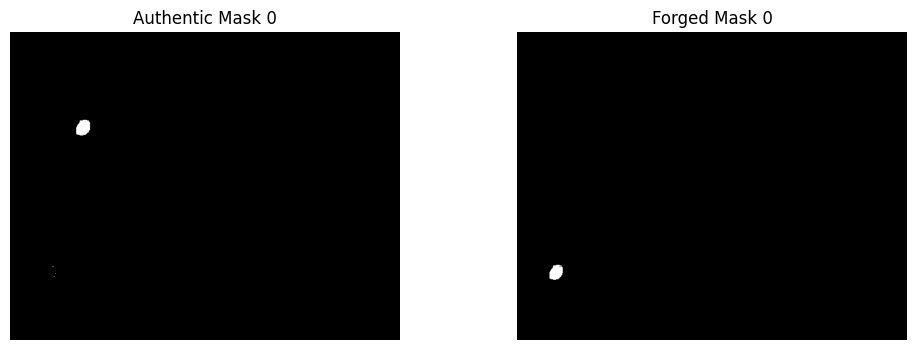

1it [00:00,  5.15it/s]


In [10]:
for i,row in tqdm(enumerate(masked_entities[:1])):
    
    forged_mask = row['forged_mask']
    auth_mask = row['auth_mask']
    
    # visualize the masks
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(auth_mask, cmap='gray')
    plt.title(f'Authentic Mask {i}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(forged_mask, cmap='gray')
    plt.title(f'Forged Mask {i}')
    plt.axis('off')
    
    
    
    plt.show()

In [4]:
# Load model

PATCH_SIZE = 16
DEFAULT_IMAGE_SIZE = 512 # Should be multiple of PATCH_SIZE

def resize_image_to_fit_patch(
    image: Image,
    image_size: int = DEFAULT_IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> Image:
    w, h = image.size
    h_hat = image_size
    w_hat = PATCH_SIZE * int(((w/h)*image_size)// PATCH_SIZE)
    resized_img = image.resize((w_hat, h_hat), \
                    resample=Image.Resampling.LANCZOS)
    return resized_img

# Available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# we take DINOv3 ViT-H
MODEL_NAME = MODEL_DINOV3_VITHP

model = torch.hub.load(
    repo_or_dir=dinov3_repo_dir,
    model=MODEL_NAME,
    source="local",
    weights=dinov3_vith16_weight_raw,
)
model.cuda()

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

In [ ]:

masked_entities_with_features = []

for row in tqdm(masked_entities):
    
    with torch.inference_mode(): 
        with torch.autocast(device_type='cuda', dtype=torch.float32):
            
            # processing Auth mask
            auth_mask = row["auth_mask"]
            auth_mask_pil = Image.fromarray((auth_mask * 255).astype(np.uint8), mode='L')
            auth_image = auth_mask_pil.convert('RGB')
            auth_image_resized = resize_image_to_fit_patch(auth_image)
            auth_image_tensor = TF.to_tensor(auth_image_resized)
            auth_image_normalized_tensor = TF.normalize(auth_image_tensor, \
                                            mean=IMAGENET_MEAN, \
                                            std=IMAGENET_STD)
            auth_image_tensorized = auth_image_normalized_tensor.unsqueeze(0).cuda()
            
            auth_feats = model.get_intermediate_layers(auth_image_tensorized, \
                                                    n=range(n_layers), \
                                                    reshape=True, \
                                                    norm=True)
            auth_patch_features = auth_feats[-1].squeeze().detach().cpu()
            
            # Convert from [D, H, W] to [H, W, D]
            auth_patch_features_2d = auth_patch_features.permute(1, 2, 0)
            
            # processing Forged mask
            forged_mask = row["forged_mask"]
            forged_mask_pil = Image.fromarray((forged_mask * 255).astype(np.uint8), mode='L')
            forged_image = forged_mask_pil.convert('RGB')
            forged_image_resized = resize_image_to_fit_patch(forged_image)
            forged_image_tensor = TF.to_tensor(forged_image_resized)
            forged_image_normalized_tensor = TF.normalize(forged_image_tensor, \
                                            mean=IMAGENET_MEAN, \
                                            std=IMAGENET_STD)
            forged_image_tensorized = forged_image_normalized_tensor.unsqueeze(0).cuda()
            
            forged_feats = model.get_intermediate_layers(forged_image_tensorized, \
                                                    n=range(n_layers), \
                                                    reshape=True, \
                                                    norm=True)
            forged_patch_features = forged_feats[-1].squeeze().detach().cpu()
            
            # Convert from [D, H, W] to [H, W, D]
            forged_patch_features_2d = forged_patch_features.permute(1, 2, 0)
            
    masked_entities_with_features.append({
        "mask_name": row["mask_name"],
        "index": row["index"],
        "auth_patch_features_2d": auth_patch_features_2d,   
        "forged_patch_features_2d": forged_patch_features_2d,
    })
    
pickle.dump(masked_entities_with_features, open('mask_components_with_features_vith.pkl', 'wb'))

  0%|          | 0/3187 [00:00<?, ?it/s]C:\Users\vishn\AppData\Local\Temp\ipykernel_21508\767933491.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  auth_mask_pil = Image.fromarray((auth_mask * 255).astype(np.uint8), mode='L')
C:\Users\vishn\AppData\Local\Temp\ipykernel_21508\767933491.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  forged_mask_pil = Image.fromarray((forged_mask * 255).astype(np.uint8), mode='L')
 37%|███▋      | 1180/3187 [2:53:56<99:54:14, 179.20s/it] 

In [25]:
flag = False
for i, row in enumerate(np.mean(np.array(auth_image_resized), axis=2)):
    for j,val in enumerate(row):
        if val == 1:
            x_coord, y_coord = i//16, j//16
            flag = True
            break
    if flag:
        break

Reference patch coordinates: (28, 23)
Cosine similarity map shape: torch.Size([100, 126])
Max similarity: 0.8715
Min similarity: -0.0875
Similarity threshold: 0.87
Number of patches above threshold: 3


C:\Users\vishn\AppData\Local\Temp\ipykernel_15448\2551757493.py:54: UserWarning: You passed both c and facecolor/facecolors for the markers. c has precedence over facecolor/facecolors. This behavior may change in the future.
  plt.scatter(high_sim_coords[1], high_sim_coords[0], c='white', s=50, marker='o',


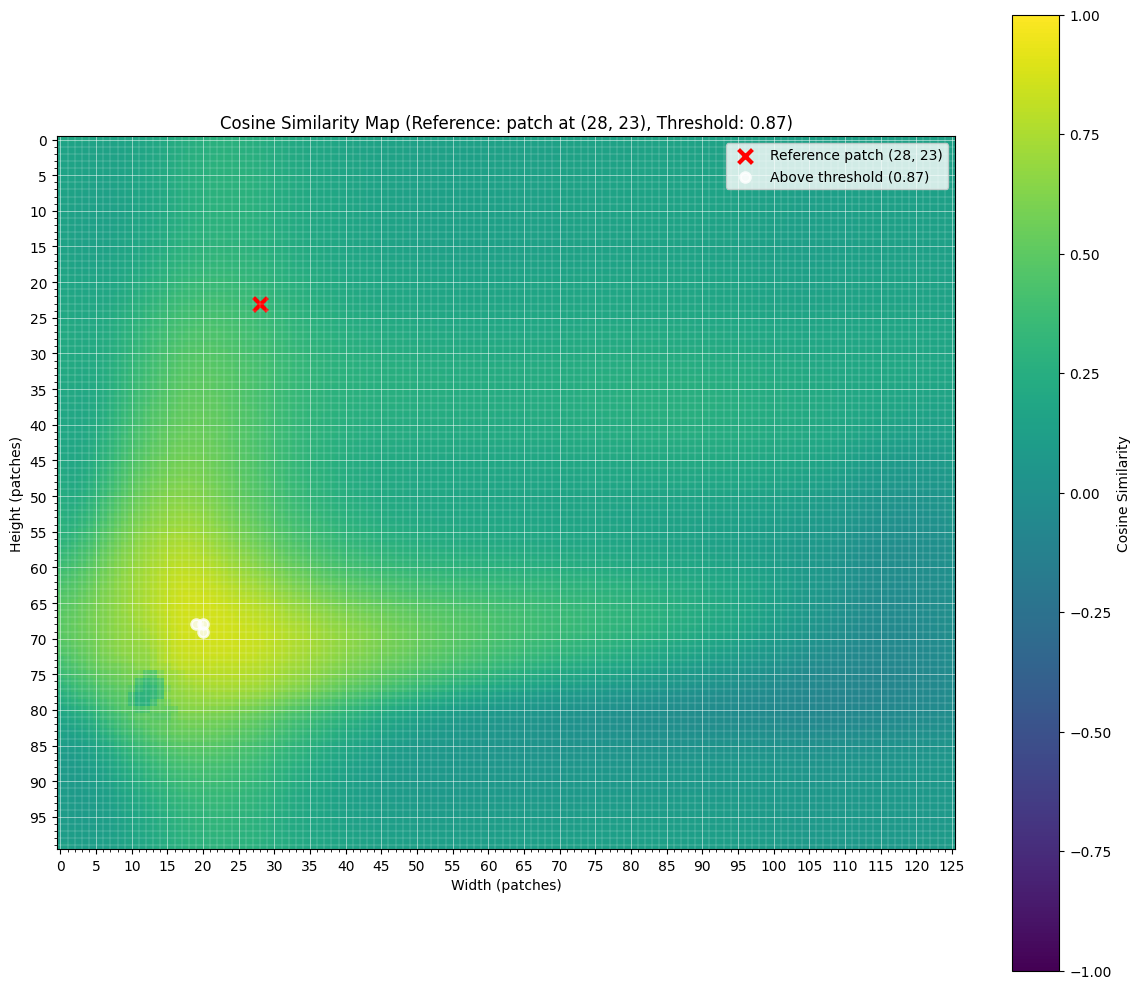

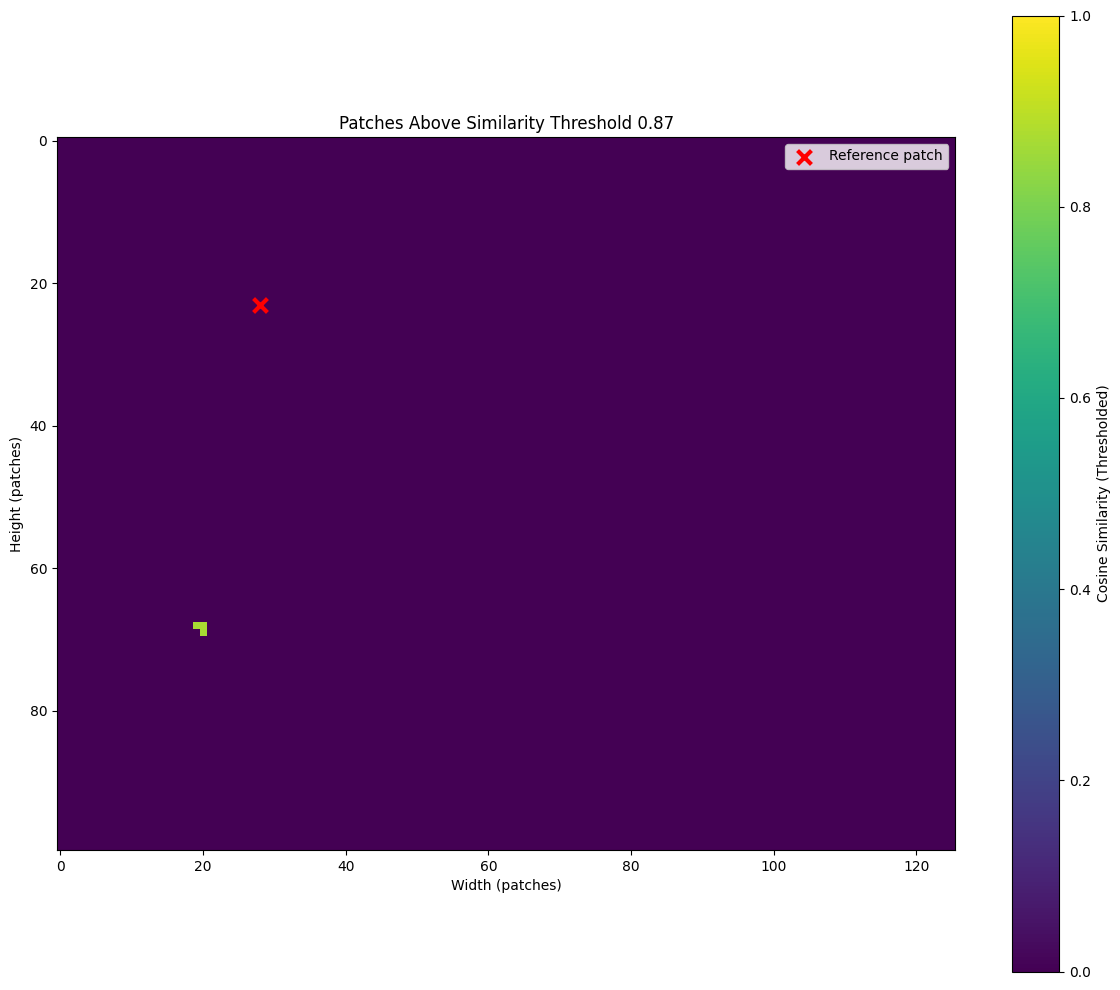

In [29]:
# Get the feature vector at the specified coordinates
auth_reference_patch = auth_patch_features_2d[y_coord, x_coord, :]  # Shape: [D]

# Reshape patch_features_2d to [H*W, D] for easier computation
H, W, D = forged_patch_features_2d.shape
patch_features_flat = forged_patch_features_2d.reshape(-1, D)  # Shape: [H*W, D]

# Calculate cosine similarity using torch.nn.functional.cosine_similarity
cosine_similarities = F.cosine_similarity(
    auth_reference_patch.unsqueeze(0),  # Shape: [1, D]
    patch_features_flat,           # Shape: [H*W, D]
    dim=1,
)

# Reshape back to 2D spatial layout
cosine_similarity_map = cosine_similarities.reshape(H, W)  # Shape: [H, W]

# Add threshold for cosine similarity
SIMILARITY_THRESHOLD = 0.87  # Adjust this value as needed

# Create a binary mask for patches above threshold
high_similarity_mask = cosine_similarity_map > SIMILARITY_THRESHOLD

print(f"Reference patch coordinates: ({x_coord}, {y_coord})")
print(f"Cosine similarity map shape: {cosine_similarity_map.shape}")
print(f"Max similarity: {cosine_similarity_map.max():.4f}")
print(f"Min similarity: {cosine_similarity_map.min():.4f}")
print(f"Similarity threshold: {SIMILARITY_THRESHOLD}")
print(f"Number of patches above threshold: {high_similarity_mask.sum()}")

# Visualize the similarity map with granular grid
plt.figure(figsize=(12, 10))
plt.imshow(cosine_similarity_map, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar(label='Cosine Similarity')
plt.title(f'Cosine Similarity Map (Reference: patch at ({x_coord}, {y_coord}), Threshold: {SIMILARITY_THRESHOLD})')
plt.xlabel('Width (patches)')
plt.ylabel('Height (patches)')

# Add granular grid
plt.grid(True, which='major', color='white', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', color='white', linewidth=0.3, alpha=0.5)

# Set major ticks every 5 patches and minor ticks every 1 patch
plt.xticks(range(0, W, 5))
plt.yticks(range(0, H, 5))
plt.gca().set_xticks(range(0, W, 1), minor=True)
plt.gca().set_yticks(range(0, H, 1), minor=True)

# Mark the reference patch
plt.scatter(x_coord, y_coord, c='red', s=100, marker='x', linewidths=3, label=f'Reference patch ({x_coord}, {y_coord})')

# Mark patches above threshold with white circles
high_sim_coords = np.where(high_similarity_mask)
plt.scatter(high_sim_coords[1], high_sim_coords[0], c='white', s=50, marker='o', 
           facecolors='none', edgecolors='white', linewidths=2, alpha=0.8, 
           label=f'Above threshold ({SIMILARITY_THRESHOLD})')

plt.legend()
plt.tight_layout()
plt.show()

# Optional: Show only patches above threshold
plt.figure(figsize=(12, 10))
thresholded_map = np.where(high_similarity_mask, cosine_similarity_map, 0)
plt.imshow(thresholded_map, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label='Cosine Similarity (Thresholded)')
plt.title(f'Patches Above Similarity Threshold {SIMILARITY_THRESHOLD}')
plt.xlabel('Width (patches)')
plt.ylabel('Height (patches)')
plt.scatter(x_coord, y_coord, c='red', s=100, marker='x', linewidths=3, label=f'Reference patch')
plt.legend()
plt.tight_layout()
plt.show()